In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from keras.layers import (
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob as gb
import cv2
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.applications import resnet

In [2]:
shape = (224, 224, 3)
image_size = 224
train_path = "./Images_Cropped_With_Augmentation/cropped_training"
test_path = "./Images_Cropped_With_Augmentation/cropped_testing"

In [3]:
def read_images_from_directory(
    folder_path,
    desc,
):
    """
    Analyzes the sizes of JPEG images within each subfolder of the given directory.

    Parameters:
    - train_path: str. The path to the directory containing subfolders of images.
    - desc: str. A description for the tqdm progress bar.

    Returns:
    - A pandas Series object with the counts of each unique image size.
    """
    images = []
    labels = []

    # Iterate through each folder in the given directory with a progress bar

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + "/" + folder + "/*.jpg"))

        # For each file in the current folder, read the image and append its size
        for file in tqdm(files, desc=desc + " in " + folder):
            image = plt.imread(file)
            img_resized = cv2.resize(image, (image_size, image_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img_rgb)
            labels.append(folder)

    # Count the occurrence of each unique size
    return images, labels

In [4]:
x_train, y_train = read_images_from_directory(train_path, "Loading Training Data")

Loading Training Data in glioma_tumor:   0%|          | 0/4130 [00:00<?, ?it/s]

Loading Training Data in pituitary_tumor: 100%|██████████| 4134/4134 [00:42<00:00, 97.33it/s] 


In [5]:
x_test, y_test = read_images_from_directory(test_path, "Loading Testing Data")

Loading Testing Data in pituitary_tumor: 100%|██████████| 370/370 [00:04<00:00, 85.18it/s] 


In [6]:
def visualize_data(list_of_images, labels):
    plt.figure(figsize=(20, 20))
    for n, i in enumerate(list(np.random.randint(0, len(list_of_images), 36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        plt.title(labels[i])

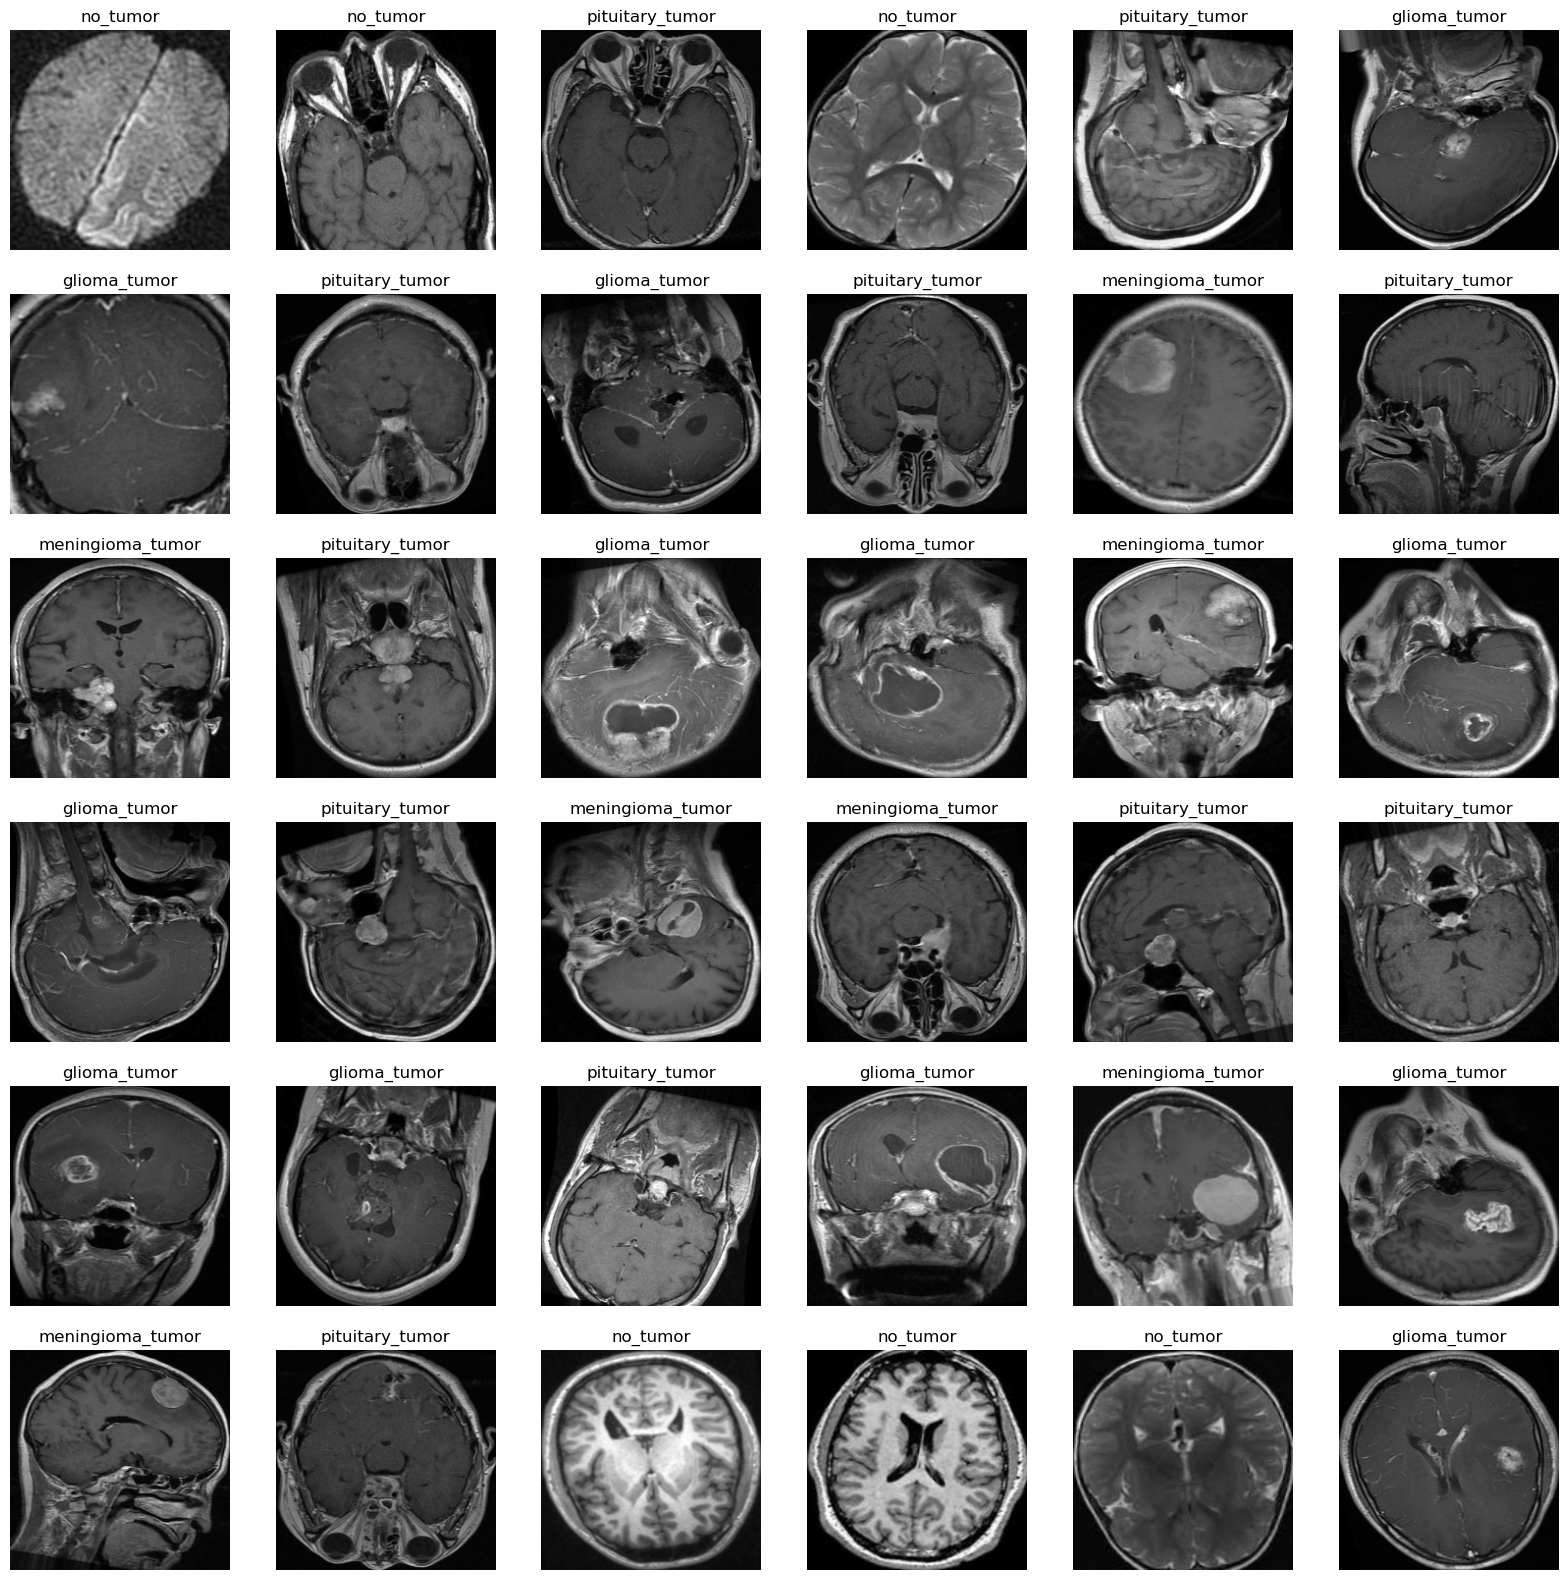

In [7]:
visualize_data(x_train, y_train)

In [8]:
def visualize_class_distribution(y_train, y_test):
    """
    Visualizes the class distribution in training and testing datasets when the labels are provided as lists.
    Adds a numeric label at the top of each bar showing the count.

    Parameters:
    - y_train: List of training labels.
    - y_test: List of testing labels.
    """
    train_counter = Counter(y_train)
    test_counter = Counter(y_test)

    all_labels = list(set(train_counter.keys()).union(set(test_counter.keys())))
    all_labels.sort()  # Sort the labels for consistent plotting
    train_counts = [train_counter[label] for label in all_labels]
    test_counts = [test_counter[label] for label in all_labels]

    x = range(len(all_labels))  # Label locations

    fig, ax = plt.subplots()
    train_bars = ax.bar(
        [i - 0.2 for i in x], train_counts, width=0.4, label="Train", align="center"
    )
    test_bars = ax.bar(
        [i + 0.2 for i in x], test_counts, width=0.4, label="Test", align="center"
    )

    ax.set_ylabel("Counts")
    ax.set_title("Class distribution in training and testing datasets")
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation="horizontal")
    ax.legend()

    def autolabel(bars):
        """Attach a text label above each bar displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                "{}".format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    autolabel(train_bars)
    autolabel(test_bars)

    plt.tight_layout()
    plt.show()

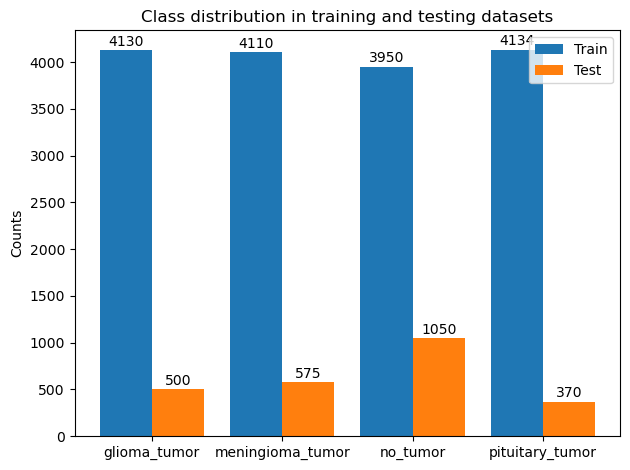

In [9]:
visualize_class_distribution(y_train, y_test)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [11]:
# Preprocess labels: convert to one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [13]:
base_model01 = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=shape)
base_model01.summary
for layer in base_model01.layers:
    layer.trainable = False

In [14]:
x01 = base_model01.output
x01 = GlobalMaxPooling2D()(x01)
x01 = Dense(1024, activation="relu")(x01)
predictions = Dense(4, activation="softmax")(x01)

In [15]:
model01 = Model(inputs=base_model01.input, outputs=predictions)

In [16]:
model01.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
history01 = model01.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.6970 - loss: 6.8445 - val_accuracy: 0.8123 - val_loss: 0.4623
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.9001 - loss: 0.2775 - val_accuracy: 0.9005 - val_loss: 0.2505
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.9182 - loss: 0.2152 - val_accuracy: 0.9253 - val_loss: 0.1968
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.9374 - loss: 0.1647 - val_accuracy: 0.8576 - val_loss: 0.3622
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.9274 - loss: 0.1999 - val_accuracy: 0.9194 - val_loss: 0.2190
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.9546 - loss: 0.1288 - val_accuracy: 0.7583 - val_loss: 0.8398
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.9501 - loss: 0.1316 - val_accuracy: 0.8190 - val_loss: 0.7123
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.9528 - loss: 0.1214 - val_accu

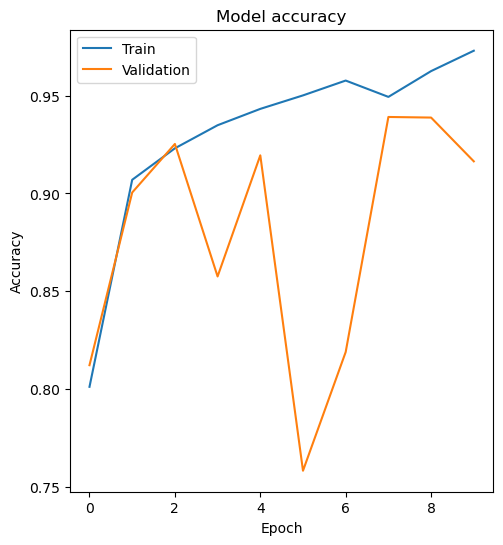

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history01.history["accuracy"])
plt.plot(history01.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

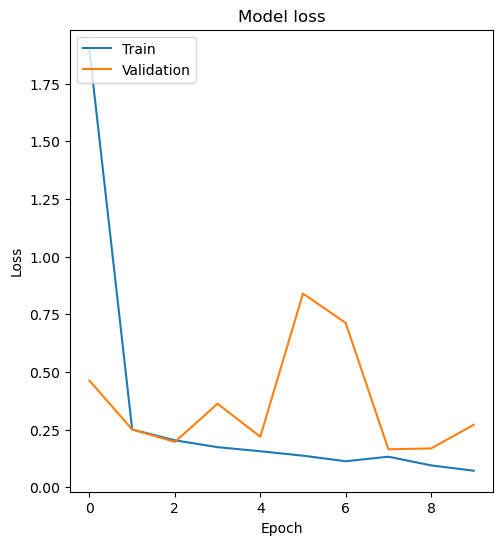

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history01.history["loss"])
plt.plot(history01.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

In [20]:
test_loss, test_acc = model01.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5267 - loss: 4.3310
Test accuracy: 0.7478957772254944
Test loss: 1.8218861818313599


In [21]:
# Make predictions on the test set
y_pred_probs = model01.predict(x_test)

y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step


In [22]:
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average="weighted")

recall = recall_score(y_true, y_pred, average="weighted")

f1 = f1_score(y_true, y_pred, average="weighted")

In [23]:
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Confusion Matrix:
[[100 291  84  25]
 [  3 521  33  18]
 [  3  88 942  17]
 [  3  45  19 303]]
Accuracy: 0.7478957915831663
Precision: 0.8024455395109965
Recall: 0.7478957915831663
F1 Score: 0.7189900181205849


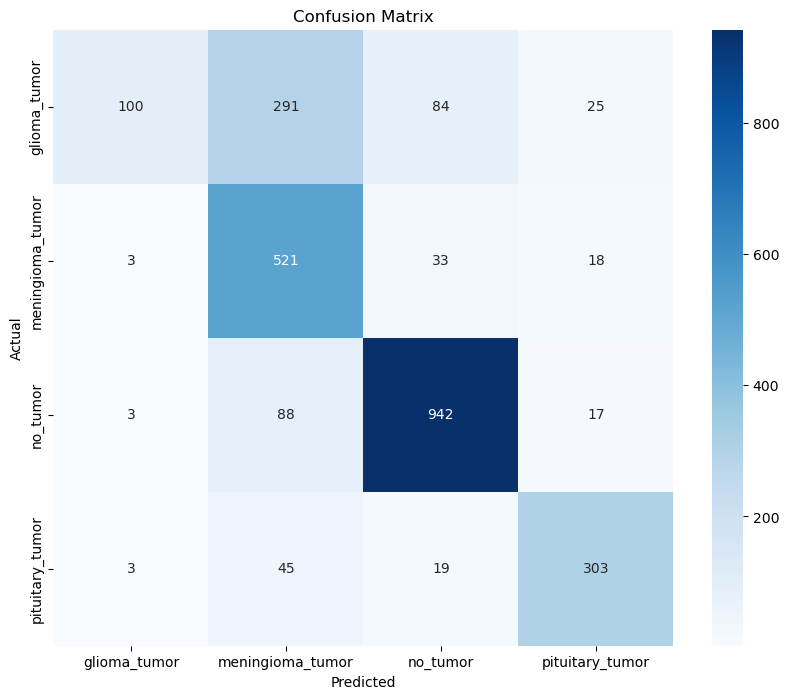

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "ResNet50_AUG_01.h5")
model01.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\ResNet50_AUG_01.h5


In [26]:
base_model02 = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=shape)
# base_model.summary
for layer in base_model02.layers:
    layer.trainable = False

In [27]:
x02 = base_model02.output
x02 = GlobalMaxPooling2D()(x02)
x02 = Dense(1024)(x02)
x02 = BatchNormalization()(x02)
x02 = Activation("relu")(x02)
x02 = Dropout(0.5)(x02)

x02 = Dense(512)(x02)
x02 = BatchNormalization()(x02)
x02 = Activation("relu")(x02)
x02 = Dropout(0.5)(x02)

predictions = Dense(4, activation="softmax")(x02)

In [28]:
model02 = Model(inputs=base_model02.input, outputs=predictions)

In [29]:
model02.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [30]:
history02 = model02.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.7790 - loss: 0.6237 - val_accuracy: 0.8511 - val_loss: 0.4190
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.9199 - loss: 0.2321 - val_accuracy: 0.9311 - val_loss: 0.1850
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.9422 - loss: 0.1568 - val_accuracy: 0.9522 - val_loss: 0.1175
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.9556 - loss: 0.1200 - val_accuracy: 0.8536 - val_loss: 0.3946
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.9666 - loss: 0.0920 - val_accuracy: 0.9528 - val_loss: 0.1321
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.9669 - loss: 0.0917 - val_accuracy: 0.9204 - val_loss: 0.2481
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.9733 - loss: 0.0810 - val_accuracy: 0.9332 - val_loss: 0.1960
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.9758 - loss: 0.0667 - val_accu

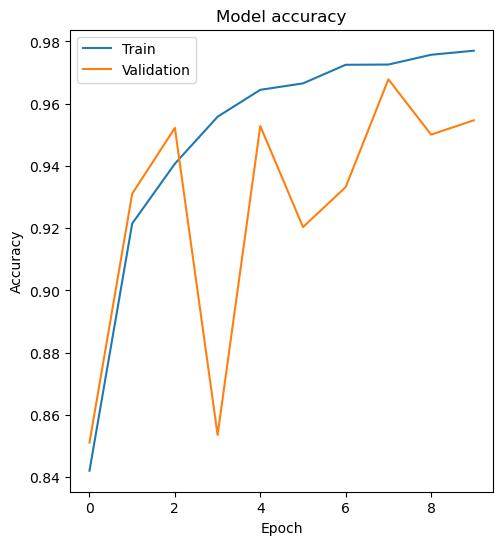

In [39]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history02.history["accuracy"])
plt.plot(history02.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

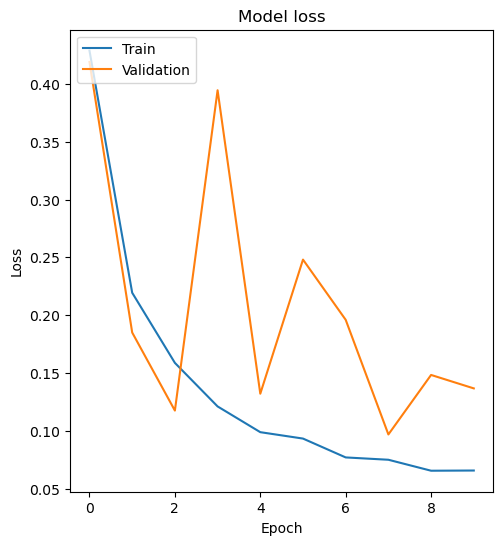

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history02.history["loss"])
plt.plot(history02.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

In [33]:
test_loss, test_acc = model02.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6443 - loss: 2.7356
Test accuracy: 0.8384769558906555
Test loss: 1.0933979749679565


In [34]:
y_pred_probs = model02.predict(x_test)

y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step


In [35]:
conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average="weighted")

recall = recall_score(y_true, y_pred, average="weighted")

f1 = f1_score(y_true, y_pred, average="weighted")

In [36]:
print(f"Confusion Matrix:\n{conf_matrix}")

print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Confusion Matrix:
[[ 196  209   73   22]
 [  15  543    6   11]
 [   1    8 1036    5]
 [  12   36    5  317]]
Accuracy: 0.8384769539078156
Precision: 0.8542632579193351
Recall: 0.8384769539078156
F1 Score: 0.8225763356367712


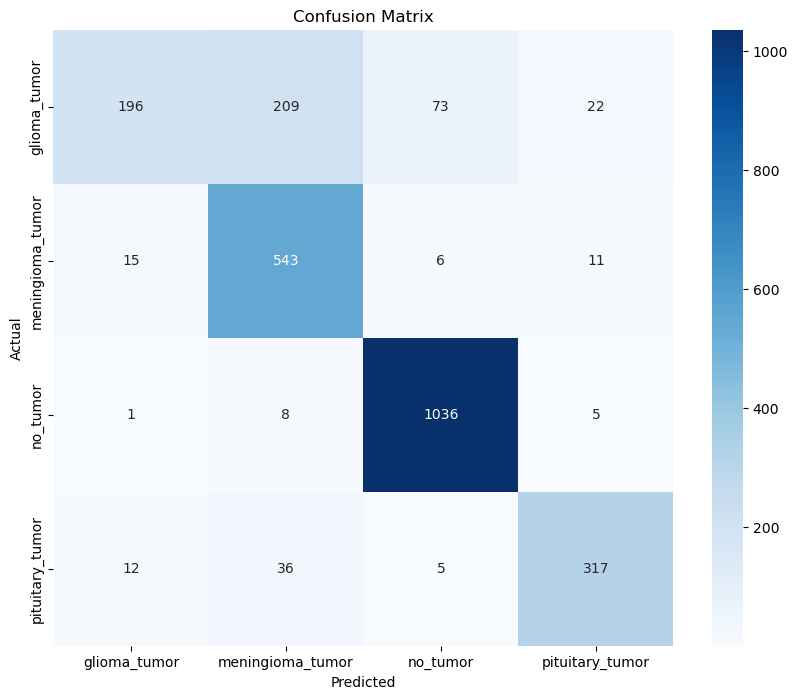

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [38]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "ResNet50_AUG_02.h5")
model01.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\ResNet50_AUG_02.h5
